# How to install CLIMaCCF library
The installation is the first step to working with CLIMaCCF.

It is highly recommended to create a virtual environment (e.g., env_climaccf) with Python versions >= 3.10:
like: conda create -n env_climaccf python==3.10

Clone or download the repository. The CLIMaCCF source code is available on a public GitHub repository: https://github.com/dlr-pa/climaccf.git. The easiest way to obtain it is to clone the repository using git: git clone https://github.com/dlr-pa/climaccf.git. Then, Locate yourself in the CLIMaCCF (library folder) path, and run the following line, using terminal (MacOS and Linux) or cmd (Windows), which will install all dependencies:

*pip install -e .*

or directly use: *pip install git+https://github.com/dlr-pa/climaccf.git*

The installation package contains a **set of sample data** and an example script for testing purposes. To run it at the library folder, enter the following command:

*pytest*

The library runs successfully if env_processed.nc is generated at the library folder/test/sample_data/. One can visualize the file using a visualization tool.

# Data description

The data needed is ERA5 reanalysis and can be obtained here Climate Data Store (https://cds.climate.copernicus.eu/). The registration to ECMWF is reguired, but it is free.

## Pressure data

The pressure data should be taken from ERA5 hourly data on pressure levels from 1940 to present dataset. The needed variables are: geopotential, potential vorticity, specific humidity, u-component of wind, relative humidity, temperature, v-component of wind. Then choose, year, month, day, time, and then pressure level. Pressure is given in hPa. The specific geographic region can be selected as well.
## Surface data
For that we need ERA5 hourly data on single levels from 1940 to present. We need the following data here TOA incident solar radiation, surface solar radiation downwards, top net thermal radiation. Then choose, year, month, day, time. The specific geographic region can be selected as well.
## Obtaining climate data 
To run the CLIMaCCF, it has to be installed, with proper python modules - the Manual contains the instructions, although some trial and error might still be required (for example pillow was not in the list of requirements, and I needed a slightly different numpy version). Then to run it:

- pick the options in the config-user.yml (simplest text editor can be used to change the options), see the Manual for explanation of options.
- add the correct paths to the input data files in the climaccf_run_main.py.

## Datasets
in the data folder.


# NetCDF

The example of structure of netCDF file:


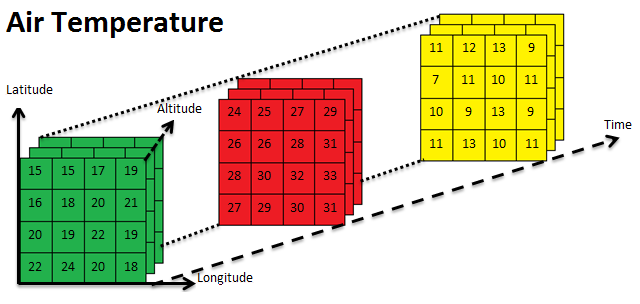

Below a couple of examples of checking the structure of the file and variables within.

In [ ]:
#To check for the shape of netcdf file
from netCDF4 import Dataset

# Open the netCDF file in read mode
nc = Dataset('./data/SEP_surface.nc')

# Print the dimensions and their sizes
print("Dimensions:")
for dim_name, dimension in nc.dimensions.items():
    print(f"  {dim_name}: {len(dimension)}")

# Print each variable and its shape
print("\nVariables and their shapes:")
for var_name, variable in nc.variables.items():
    print(f"  {var_name}: {variable.shape}")

# Close dataset
nc.close()

In [ ]:
#extracting distinct value of a variable
import xarray as xr
import numpy as np

# Open the NetCDF file
file_path = "./data/SEP_pressure.nc"  # Replace with your actual file
ds = xr.open_dataset(file_path)

# Extract the 'level' variable
if 'time' in ds.variables:
    time_values = ds['time'].values  # Convert to NumPy array
    unique_time = np.unique(time_values)  # Get unique values
    print("Distinct time values:", unique_time)
else:
    print("Variable 'time' not found in the NetCDF file.")

# Close dataset
ds.close()

In [ ]:
#To extract the latitude and longitude range
import netCDF4

# Path to your NetCDF file
file_path = './data/SEP_surface.nc'

# Open the NetCDF file
dataset = netCDF4.Dataset(file_path, 'r')

# Get latitude and longitude variables
lats = dataset.variables['latitude'][:]
lons = dataset.variables['longitude'][:]

# Find the range of latitude and longitude
lat_range = (lats.min(), lats.max())
lon_range = (lons.min(), lons.max())

# Print the latitude and longitude range
print(f"Latitude range: {lat_range}")
print(f"Longitude range: {lon_range}")

# Close the dataset
dataset.close()


# Running CLIMaCCF library

Open the 'config-user.yml' file that is located in the climaccf library folder.

We need to change the following settings:
- **NOx_EI&F_km** - change to 'ac_dependent'
- **ac_type** - change to 'single-aisle'
- **NOx_aCCF** - change to true
- **unit_K/kg(fuel)** - change to true
- **merged** - change to true
- **geojson** - change to false (this and other settings can be changed if you want to get automated 'hotspot' calculation)
- **horizontal_resolution:** change to **0.25**
- **forecast_step:** change to 1

Save the file

In [ ]:
import sys
sys.path.insert(0, r'C:\Users\bolict\PycharmProjects\climaccf') #this is the path to local where the climaccf can be found  #change to your path, or just run if in the same virtual environment


In [ ]:
import yaml
import climaccf
from climaccf.main_processing import ClimateImpact

path_here = 'C:\\Users\\bolict\\PycharmProjects\\climaccf\\climaccf' #path to climaccf library on your pc
test_path = './data/' #path to the data folder
input_dir = {'path_pl': test_path + 'SEP_pressure.nc', 'path_sur': test_path + 'SEP_surface.nc', 'path_lib': path_here} #paths to input and output data files, as recognised in the library
output_dir = test_path + 'env_processed'

""" %%%%%%%%%%%%%%%%% LOAD CONFIGURATIONS %%%%%%%%%%%%%%%% """

with open("C:\\Users\\bolict\\PycharmProjects\\climaccf\\config-user.yml", "r") as ymlfile:#path where the config-user.yml file is
    confg = yaml.safe_load(ymlfile)

""" %%%%%%%%%%%%%%%%% MAIN %%%%%%%%%%%%%%%% """

CI = ClimateImpact(input_dir, output_dir, **confg)
CI.calculate_accfs(**confg)

In [ ]:
#finding the value of the accfs at the certain point in airspace (lato, lon, altitude, time)
import netCDF4 as nc
import numpy as np

# Open the NetCDF file
ds = nc.Dataset('./data/env_processed.nc', 'r')

# Extract coordinate arrays (adjust these variable names as needed)
lats = ds.variables['latitude'][:]   # or 'lat'
lons = ds.variables['longitude'][:]  # or 'lon'
levels = ds.variables['level'][:]      # adjust if the variable name is different
times = ds.variables['time'][:]        # if you need to choose a specific time index

# Define the target coordinates and level
target_lat = 40.0      # for example
target_lon = 10.0    # for example
target_level = 250   # for example (keep in mind this is pressure level)
time_index = 2      # or a specific index if needed

# Find the nearest indices for latitude, longitude, and level
lat_idx = np.abs(lats - target_lat).argmin()
lon_idx = np.abs(lons - target_lon).argmin()
level_idx = np.abs(levels - target_level).argmin()

# Extract values from the variables at the specified indices
value_aCCF_merged = ds.variables['aCCF_merged'][time_index, level_idx, lat_idx, lon_idx]
value_aCCF_NOx    = ds.variables['aCCF_NOx'][time_index, level_idx, lat_idx, lon_idx]

print("aCCF_merged:", value_aCCF_merged)
print("aCCF_NOx:", value_aCCF_NOx)

# Close the dataset when done
ds.close()

## Determining 'hotspot' areas

The non-CO2 emissions depend on the state of the atmosphere, on the aircraft type (i.e. engine), and fuel composition. We are addressing aircraft type and atmosphere here.

We want to determine the threshold for non-CO2 emissions, for a chosen single-aisle aircraft over a period of time we have in the dataset. Note that atmosphere has seasonal changes as well.

We turn to calculation of percentiles to choose a threshold. The actual meeaning of such thresholds needs to be discussed with atmospheric scientists.


In [ ]:
#calculating the percentiles of accf_merged variable for the entire dataset
import xarray as xr

# Load the NetCDF dataset
ds = xr.open_dataset('./data/env_processed.nc')

# Define the desired percentiles
percentiles = [0.90, 0.95, 0.99]
data_subset = ds['aCCF_merged']
df = data_subset.to_dataframe(name='aCCF_merged').reset_index()
res = df['aCCF_merged'].quantile(percentiles)
ds.close()
res

In [ ]:
# Adding the hotspot variable based on the above calculated threshold value
import xarray as xr

# Open the NetCDF file
ds = xr.open_dataset('./data/env_processed.nc', engine="netcdf4")

# Insert the chosen threshold value (use one of the percentiles above)
comparison_value =

# Create the binary variable
binary_mask = (ds["aCCF_merged"] > comparison_value).astype(int)

# Assign the binary mask to the dataset with a meaningful name
ds["hotspot"] = binary_mask

# Add attributes to the new variable for metadata
ds["hotspot"].attrs = {
    "description": "Binary mask where 1 indicates aCCF_merged > threshold, 0 otherwise",
    "source": "Derived from aCCF_merged and percentile threshold",
    "valid_range": "0 to 1",
    "units": "binary"
}

# Save to a new NetCDF file
ds.to_netcdf('./data/env_processedH.nc')
ds.close()

print(f"Modified NetCDF file saved as {'./data/env_processedH.nc'}")

In [ ]:
#To check for the shape of netcdf file
from netCDF4 import Dataset

# Open the netCDF file in read mode
nc = Dataset('./data/env_processedH.nc', 'r')

# Print the dimensions and their sizes
print("Dimensions:")
for dim_name, dimension in nc.dimensions.items():
    print(f"  {dim_name}: {len(dimension)}")

# Print each variable and its shape
print("\nVariables and their shapes:")
for var_name, variable in nc.variables.items():
    print(f"  {var_name}: {variable.shape}")

nc.close()

## Creating maps

In [ ]:
# Generating gojson from netcdf, as clima library can stop generating if large number of files.
import xarray as xr
import geopandas as gpd
import json
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import os
import pandas as pd

# Define the output directory
output_dir ='./data/json'  # Change this to your desired folder

# Ensure the folder exists
os.makedirs(output_dir, exist_ok=True)

# Open the NetCDF file
file_path = './data/env_processedH.nc'  # Update with your actual file path
ds = xr.open_dataset(file_path)

# Extract coordinates
lats = ds["latitude"].values
lons = ds["longitude"].values

# Iterate over time and level to create GeoJSONs
for t in ds.time:
    time_value = t.values  # Gets a numpy datetime64 object
    # Convert to a Python datetime object
    time_datetime = pd.to_datetime(time_value)
    time_str = time_datetime.strftime("%Y-%m-%dT%H")  # Convert to "YYYY-MM-DD"
    for lvl in ds.level:
        data_slice = ds["hotspot"].sel(time=t, level=lvl).values

        polygons = []
        for lat_idx in range(len(lats) - 1):
            for lon_idx in range(len(lons) - 1):
                if data_slice[lat_idx, lon_idx] == 1:
                    # Get the four corners of the grid cell
                    lon_min, lon_max = lons[lon_idx], lons[lon_idx + 1]
                    lat_min, lat_max = lats[lat_idx], lats[lat_idx + 1]

                    # Create a polygon from the bounding box
                    polygon = Polygon([
                        (lon_min, lat_min),
                        (lon_max, lat_min),
                        (lon_max, lat_max),
                        (lon_min, lat_max),
                        (lon_min, lat_min)
                    ])
                    polygons.append(polygon)

        # Merge adjacent polygons into a single shape
        merged_polygons = unary_union(polygons)

        # Convert to GeoJSON format
        if isinstance(merged_polygons, Polygon):
            geojson_data = {"type": "FeatureCollection", "features": [
                {
                    "type": "Feature",
                    "geometry": json.loads(json.dumps(merged_polygons.__geo_interface__)),
                    "properties": {"time": time_str, "level": int(lvl)}
                }
            ]}
        elif isinstance(merged_polygons, MultiPolygon):
            geojson_data = {"type": "FeatureCollection", "features": [
                {
                    "type": "Feature",
                    "geometry": json.loads(json.dumps(poly.__geo_interface__)),
                    "properties": {"time": time_str, "level": int(lvl)}
                }
                for poly in merged_polygons.geoms
            ]}

        # Convert merged polygons into a GeoDataFrame
        gdf = gpd.GeoDataFrame(
            {"geometry": [merged_polygons], "time": time_str, "level": int(lvl)},
            crs="EPSG:4326"  # Set the coordinate reference system
        )

        # Define full file path inside the folder
        geojson_filename = os.path.join(output_dir, f"Chspot{time_str}_{lvl.values}.geojson")

        # Save GeoJSON file
        gdf.to_file(geojson_filename, driver="GeoJSON")
        print(f"Saved: {geojson_filename}")

# Close the NetCDF file
ds.close()


In [ ]:
# Create colormap for different pressure levels to use in the map plot
import matplotlib.cm as cm
import matplotlib.colors as colors

# Define the available pressure levels (from low to high)
pressure_levels = [125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 775]

# Create a colormap from blue (low) to red (high)
colormap = cm.get_cmap('coolwarm', len(pressure_levels))  # Try 'viridis', 'plasma', or 'coolwarm'

# Generate a dictionary mapping each pressure level to a color
pressure_colors = {
    str(pressure): colors.to_hex(colormap(i / (len(pressure_levels) - 1)))
    for i, pressure in enumerate(pressure_levels)
}

print("Generated colors for pressure levels:", pressure_colors)  # Debugging to check colors


In [ ]:
import os
import re
import folium
import geopandas as gpd

# Folder where the GeoJSON files are stored
folder_path = './data/json/'

# Choose the specific time slice
target_date = '2019-09-26'   # change this to your desired date
target_hour = '12'           # change this to your desired hour

# Dictionary to store GeoJSONs grouped by date and pressure
geojson_by_date_and_pressure = {}

# Loop through the files and group them by date and pressure
for filename in os.listdir(folder_path):
    if filename.endswith(".geojson") and filename.startswith("Chspot"):
        match = re.search(r'Chspot(\d{4}-\d{2}-\d{2})T(\d{2})_(\d{3})', filename)
        if match:
            date = match.group(1)
            hour = match.group(2)
            pressure = match.group(3)

            # Only load data for the target date and hour
            if date == target_date and hour == target_hour:
                file_path = os.path.join(folder_path, filename)
                geojson = gpd.read_file(file_path)

                if date not in geojson_by_date_and_pressure:
                    geojson_by_date_and_pressure[date] = {}
                if pressure not in geojson_by_date_and_pressure[date]:
                    geojson_by_date_and_pressure[date][pressure] = []

                geojson_by_date_and_pressure[date][pressure].append({
                    'filename': filename,
                    'hour': hour,
                    'data': geojson
                })

# Create one folium map for the target date and hour
if target_date in geojson_by_date_and_pressure:
    m = folium.Map(location=[48, 12], zoom_start=4.5)

    for pressure, geojson_files in geojson_by_date_and_pressure[target_date].items():
        color = pressure_colors.get(str(pressure), 'black')
        opacity = 0.6

        for file_info in geojson_files:
            geojson_data = file_info['data']
            folium.GeoJson(
                geojson_data,
                name=f"{target_hour}:00 - Pressure {pressure}",
                style_function=lambda feature, col=color, op=opacity: {
                    'color': col,
                    'weight': 2,
                    'fillOpacity': op
                }
            ).add_to(m)

    folium.LayerControl().add_to(m)

    map_filename = f"map_{target_date}_{target_hour}h_single.html"
    m.save(map_filename)
    print(f"✅ Map for {target_date} at {target_hour}:00 saved as {map_filename}")
else:
    print(f"⚠️ No GeoJSON data found for {target_date} at {target_hour}:00")


# Trajectory sourcing and non-CO2 impact estimation


## Functions needed
- pressure calculation - to convert Flight Level to pressure, to make it easier to search netCDF files
- computation of speed and time from location points - to be able to calculate **fuel flow**
- get maximum take-off weight (MTOW) - to be able to calculate **fuel flow**
- fuel flow - to be able to calculate fuel consumption, CO2, and non-CO2 impacts

## Data

We will source trajectory data from R&D.
MTOW data given below.
Environmental data prepared above.


In [ ]:
import pandas as pd
# Flight Points Actual
df_points_actual = pd.read_csv('./data/Flight_Points_Actual_20230901_20230930.csv.gz')

In [ ]:
# Example of a flight
ectrl_id = 264871616#264872801#
df_trajectory=df_points_actual[df_points_actual["ECTRL ID"] == ectrl_id].copy()
df_trajectory

In [ ]:
df_flights = pd.read_csv('./data/Flights_20230901_20230930.csv.gz')

In [ ]:
df_flights[df_flights["ECTRL ID"] == ectrl_id].head()

In [ ]:
# For the ease of handling in functions
df_trajectory.rename(columns={'Flight Level': 'FL'}, inplace=True)

In [ ]:
aircraft_df = df_flights.loc[df_flights["ECTRL ID"]==ectrl_id]
aircraft=aircraft_df["AC Type"].values[0]
aircraft

### Function to return the MTOW from the three-letter aircraft type code

The fuel consumption and overall aircraft performance depend on the aircraft weight, speed and altitude. Which is the reason for getting the maximum take-off weight.

You can check this website for different aircraft performance details: https://learningzone.eurocontrol.int/ilp/customs/ATCPFDB/default.aspx?ICAOFilter=a320

In [ ]:
aircraft_mtow = {
    'A318': 68000,   # Airbus A318
    'A319': 70000,   # Airbus A319
    'A320': 73900,   # Airbus A320
    'A321': 83000,   # Airbus A321
    'A20N': 79000,   # Airbus A320neo   *
    'A21N': 89000,   # Airbus A321neo   *
    'A306': 171700,  # Airbus A300-600
    'A332': 230000,  # Airbus A330-200
    'A333': 212000,  # Airbus A330-300
    'A343': 276500,  # Airbus A340-300
    'A346': 365000,  # Airbus A340-600
    'A359': 268000,  # Airbus A350-900
    'B733': 62800,   # Boeing 737-300
    'B734': 68000,   # Boeing 737-400
    'B735': 60680,   # Boeing 737-500
    'B737': 70080,   # Boeing 737-700
    'B738': 78300,   # Boeing 737-800
    'B739': 85139,   # Boeing 737-900
    'B752': 115680,  # Boeing 757-200
    'B763': 186880,  # Boeing 767-300ER
    'B772': 287000,  # Boeing 777-200ER
    'B77L': 347450,  # Boeing 777-200LR
    'B77W': 351530,  # Boeing 777-300ER
    'B788': 227930,  # Boeing 787-8
    'B789': 250830,  # Boeing 787-9
    'B744': 396800,  # Boeing 747-400
    'CRJ9': 38000,   # Bombardier CRJ900
    'CRJX': 38000,   # Bombardier CRJ1000
    'E145': 22000,   # Embraer ERJ145
    'E195': 52290,   # Embraer 195
    'E190': 45995,    # Embraer 190
    'C680': 13744,    # Cessna Citation Sovereign
    'C68A': 13744,    # Cessna Citation Latitude
    'C750': 16193,    # Cessna Citation X
    'CL35': 17962,    # Bombardier Challenger 350
    'F2TH': 19142,   # Dassault Falcon 2000
    'GLEX': 45132,   # Bombardier Global Express
    'GLF5': 41277,   # Gulfstream G550

}

In [ ]:
def get_mtow(aircraft_code):
    """
    Returns the Maximum Takeoff Weight (MTOW) for the given aircraft code.

    Parameters:
    aircraft_code (str): The code of the aircraft model.

    Returns:
    int: MTOW in kilograms if the aircraft code is found.
    None: If the aircraft code is not found.
    """
    aircraft_code = aircraft_code.upper()
    if aircraft_code in aircraft_mtow:
        return aircraft_mtow[aircraft_code]
    else:
        return None

In [ ]:
mass = get_mtow(aircraft)
mass

### Function to compute time and speed and vertical rate

These data are needed for fuel flow calculations in the openap library.

Take care of the **units** used in all calculations.

In [ ]:
from geopy.distance import geodesic

def compute_speed_vs_time(df):
    """
    calculate ground speed (GS) in knots and time difference between each point in the trajectory
    """

    # Parse Timestamp (assuming format YYYYMMDDhhmmss)
    df['Time Over'] = pd.to_datetime(df['Time Over'], format="%d-%m-%Y %H:%M:%S")

    # Sort by time just in case
    df = df.sort_values('Time Over').reset_index(drop=True)

    # Time difference in seconds
    df['gap'] = df['Time Over'].diff().dt.total_seconds()

    # Distance in km between each point and the previous
    # Compute speed in knots
    df['GS'] = [int((geodesic((df.loc[i - 1, 'Latitude'], df.loc[i - 1, 'Longitude']),
                              (df.loc[i, 'Latitude'], df.loc[i, 'Longitude'])).nm
                     / df.loc[i, 'gap']) * 3600)

                if i > 0 else np.nan
                for i in range(len(df))
                ]
    # compute vertical speed
    df['vertical_rate'] = [int((((df.loc[i, 'FL'] - df.loc[i - 1, 'FL']) * 100) / df.loc[i, 'gap']) * 60)
                           if i > 0 else np.nan
                           for i in range(len(df))]

    # Set first point to zero instead of NaN
    df['gap'] = df['gap'].fillna(0)
    df['GS'] = df['GS'].fillna(0)
    df['vertical_rate'] = df['vertical_rate'].fillna(0)

    return df

In [ ]:
df_trajectory = compute_speed_vs_time(df_trajectory)

### Fuel flow and fuel calculation
By using openap library.

The handbook is here: https://openap.dev/

In [ ]:
import openap

def fuel_flow(ac_type, mass, df_traj):
    fuelflow = openap.FuelFlow(ac=ac_type, use_synonym=True)
    mass_current = mass*0.8

    fuelflow_every_step = []
    fuel_every_step = []

    for i, row in df_traj.iterrows():
        if row.GS>0:
            ff = fuelflow.enroute(
                mass=mass_current,  # in kg
                tas=row.GS,  # in kts
                alt=row.FL * 100,  # in ft
                vs=row.vertical_rate,  # ft/min
            )
        else:
            ff=0
        fuel = ff * row.gap  # kg/sec
        fuelflow_every_step.append(ff)
        fuel_every_step.append(ff * row.gap)  # kg
        mass_current -= fuel

    df_traj = df_traj.assign(fuel_flow=fuelflow_every_step, fuel=fuel_every_step)
    return df_traj

In [ ]:
df_trajectory = fuel_flow(aircraft, mass, df_trajectory)

In [ ]:
df_trajectory

### Pressure calculation function

In [ ]:
def calculate_pressure(FL):
    """
    P0 = 1013.25  # Sea level standard pressure in hPa
    T0 = 288.15   # Sea level standard temperature in Kelvin
    L = 0.0065    # Temperature lapse rate in K/m
    R = 287.05    # Specific gas constant for dry air in J/(kg·K)
    g = 9.80665   # Gravitational acceleration in m/s^2
    """
    # Convert flight level to altitude in meters (1 FL = 100 feet)
    altitude = FL * 100 * 0.3048  # in meters
    # Pressure formula for the troposphere (below 11 km / 36,089 ft)
    if altitude <= 11000:
        pressure = 1013.25 * (1 - (0.0065 * altitude) / 288.15)**(9.80665 / (287.05 * 0.0065))
    # Above 11 km, temperature is constant (-56.5°C or 216.65 K)
    else:
        T_tropopause = 288.15 - 0.0065 * 11000
        P_tropopause = 1013.25 * (1 - (0.0065 * 11000) / 288.15)**(9.80665 / (287.05 * 0.0065))
        pressure = P_tropopause * np.exp(-9.80665 * (altitude - 11000) / (287.05 * T_tropopause))
    return pressure

In [ ]:
df_trajectory['pressure_Level'] = df_trajectory['FL'].apply(calculate_pressure).astype(int)

In [ ]:
df_trajectory

# Task
Find the environmental impact of the flight with the data prepared in df_trajectory and env_processedH.nc. Keep in mind that the weather data is for a different period when compared to the flight data (i.e. pick a day, and just keep the time of the fligth within a day).
